# ACF Benchmark: Direct vs FFT vs AR(p) vs EWMA

This notebook implements an end-to-end, apples-to-apples comparison of four ACF estimator families:

1. Direct method (biased and unbiased normalization variants)
2. FFT-based method (aperiodic ACF with zero-padding)
3. Parametric AR(p) method (Yule-Walker)
4. Recursive EWMA method

The workflow follows:

1. Fix experiment knobs (`N`, `K`, signal + method parameters)
2. Generate a WSS-compatible sinusoid + AWGN process
3. Compute a theoretical reference ACF
4. Run timing benchmarks (multiple repeats, median + IQR)
5. Run statistical sensitivity benchmarks (MSE vs `N`)
6. Summarize measured results, asymptotic complexity, and practical pros/cons


In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import sys
from time import perf_counter
from typing import Callable, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.typing import NDArray

# Ensure project root is importable when launching Jupyter from notebooks/.
project_root = Path.cwd()
if not (project_root / "common").exists():
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from common.awgn import awgn

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.4g}".format

pd.options.display.max_colwidth = None


In [2]:
@dataclass(frozen=True)
class BenchmarkConfig:
    """Stores global and method-specific knobs for the ACF benchmark."""

    n_list: tuple[int, ...]  # Record lengths to benchmark [samples]
    max_lag_mode: Literal["fixed", "full"]  # Fixed K or full ACF up to N-1
    fixed_max_lag: int  # Used only when max_lag_mode == "fixed" [samples]
    amplitude: float  # Sinusoid amplitude A
    normalized_frequency: float  # Normalized frequency f0 [cycles / sample]
    snr_db: float  # Target signal-to-noise ratio [dB]
    ar_order: int  # AR model order p
    ewma_lambda: float  # EWMA forgetting factor lambda
    repeats_timing: int  # Repeats per timing measurement
    realizations_error: int  # Monte-Carlo realizations for MSE-vs-N
    seed: int  # Base RNG seed for reproducibility


def resolve_max_lag(
    n_samples: int,  # Number of available samples N [samples]
    cfg: BenchmarkConfig,  # Global benchmark configuration
) -> int:  # Lag ceiling K [samples]
    """Returns the lag ceiling K according to the selected lag policy."""
    if n_samples < 2:
        raise ValueError("n_samples must be >= 2 to estimate non-trivial lags.")

    if cfg.max_lag_mode == "full":
        return n_samples - 1

    if cfg.max_lag_mode == "fixed":
        return min(cfg.fixed_max_lag, n_samples - 1)

    raise ValueError(f"Unsupported max_lag_mode: {cfg.max_lag_mode!r}")


def ewma_effective_memory_samples(
    forgetting_factor: float,  # EWMA forgetting factor lambda in (0, 1)
) -> float:  # Effective memory horizon [samples]
    """Approximates EWMA effective memory as 1 / (1 - lambda)."""
    if not 0.0 < forgetting_factor < 1.0:
        raise ValueError("forgetting_factor must be strictly between 0 and 1.")
    return 1.0 / (1.0 - forgetting_factor)


CONFIG = BenchmarkConfig(
    n_list=(256, 512, 1024, 2048, 4096),
    max_lag_mode="fixed",  # Use "full" for K = N - 1 benchmark mode.
    fixed_max_lag=512,
    amplitude=1.0,
    normalized_frequency=0.08,
    snr_db=5.0,
    ar_order=12,
    ewma_lambda=0.98,
    repeats_timing=11,
    realizations_error=60,
    seed=20260219,
)

print(CONFIG)
print(f"EWMA effective memory ~= {ewma_effective_memory_samples(CONFIG.ewma_lambda):.2f} samples")


BenchmarkConfig(n_list=(256, 512, 1024, 2048, 4096), max_lag_mode='fixed', fixed_max_lag=512, amplitude=1.0, normalized_frequency=0.08, snr_db=5.0, ar_order=12, ewma_lambda=0.98, repeats_timing=11, realizations_error=60, seed=20260219)
EWMA effective memory ~= 50.00 samples


In [3]:
def generate_benchmark_signal(
    n_samples: int,  # Number of samples N [samples]
    amplitude: float,  # Sinusoid amplitude A
    normalized_frequency: float,  # Normalized frequency f0 [cycles / sample]
    snr_db: float,  # Target SNR [dB]
    rng: np.random.Generator,  # RNG for phase and AWGN generation
) -> NDArray[np.float64]:  # Noisy benchmark signal x[n]
    """Generates x[n] = A cos(2*pi*f0*n + Phi) + w[n] with random phase.

    Purpose
    -------
    Builds the benchmark process where random phase `Phi ~ U[-pi, pi]` makes the
    sinusoidal component wide-sense stationary across realizations.

    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    amplitude : float
        Sinusoid amplitude A.
    normalized_frequency : float
        Frequency in cycles/sample.
    snr_db : float
        Requested signal-to-noise ratio in decibels.
    rng : np.random.Generator
        Generator consumed by random phase and AWGN draws.

    Returns
    -------
    NDArray[np.float64]
        Noisy signal with shape `(n_samples,)`.

    Side Effects
    ------------
    Consumes random numbers from `rng`.
    """
    if n_samples <= 0:
        raise ValueError("n_samples must be positive.")

    # Draw one random phase per realization to induce WSS behavior in the sinusoid.
    phase_rad = rng.uniform(-np.pi, np.pi)

    # Build the deterministic sinusoid, then perturb it with validated AWGN utility.
    n_idx = np.arange(n_samples, dtype=np.float64)
    clean_signal = amplitude * np.cos(2.0 * np.pi * normalized_frequency * n_idx + phase_rad)
    noisy_signal = awgn(clean_signal, snr_db=snr_db, rng=rng, preserve_dtype=False)

    return noisy_signal.astype(np.float64, copy=False)


def theoretical_autocovariance(
    max_lag: int,  # Highest lag K [samples]
    amplitude: float,  # Sinusoid amplitude A
    normalized_frequency: float,  # Normalized frequency f0 [cycles / sample]
    snr_db: float,  # Signal-to-noise ratio [dB]
) -> NDArray[np.float64]:  # Reference autocovariance r_x[k], k=0..K
    """Computes r_x[k] = (A^2/2) cos(2*pi*f0*k) + sigma_w^2 delta[k].

    Purpose
    -------
    Provides the analytic reference used to evaluate statistical sensitivity
    (MSE vs sample size) for the benchmark process.

    Parameters
    ----------
    max_lag : int
        Highest lag to evaluate.
    amplitude : float
        Sinusoid amplitude A.
    normalized_frequency : float
        Frequency in cycles/sample.
    snr_db : float
        Signal-to-noise ratio in decibels.

    Returns
    -------
    NDArray[np.float64]
        Reference autocovariance for lags 0..max_lag.

    Side Effects
    ------------
    None.
    """
    if max_lag < 0:
        raise ValueError("max_lag must be non-negative.")

    signal_power = 0.5 * amplitude * amplitude
    snr_linear = np.power(10.0, snr_db / 10.0)
    noise_power = signal_power / snr_linear

    lags = np.arange(max_lag + 1, dtype=np.float64)

    # The random-phase sinusoid contributes the cosine covariance profile.
    reference = signal_power * np.cos(2.0 * np.pi * normalized_frequency * lags)

    # AWGN affects only lag zero through the Kronecker delta term.
    reference[0] += noise_power
    return reference


In [4]:
def center_signal(
    x_t: NDArray[np.float64],  # Input record x[n]
) -> NDArray[np.float64]:  # Zero-mean version of x[n]
    """Subtracts the sample mean so all estimators share identical preprocessing."""
    return x_t - np.mean(x_t)


def _acf_direct_from_centered(
    x_centered_t: NDArray[np.float64],  # Mean-removed signal x[n]
    max_lag: int,  # Highest lag K [samples]
    normalization: Literal["biased", "unbiased"],  # Denominator convention
) -> NDArray[np.float64]:  # ACF estimate for k=0..K
    """Computes direct lag products assuming signal is already zero-mean."""
    n_samples = x_centered_t.size
    if n_samples < 2:
        raise ValueError("At least two samples are required for ACF estimation.")

    k_max = min(max_lag, n_samples - 1)
    acf = np.empty(k_max + 1, dtype=np.float64)

    # Evaluate each lag with the selected normalization rule.
    for lag in range(k_max + 1):
        numerator = float(np.dot(x_centered_t[: n_samples - lag], x_centered_t[lag:]))
        if normalization == "biased":
            denominator = n_samples
        elif normalization == "unbiased":
            denominator = n_samples - lag
        else:
            raise ValueError("normalization must be 'biased' or 'unbiased'.")
        acf[lag] = numerator / denominator

    return acf


def acf_direct(
    x_t: NDArray[np.float64],  # Input signal record
    max_lag: int,  # Highest lag K [samples]
    normalization: Literal["biased", "unbiased"] = "biased",  # Denominator policy
) -> NDArray[np.float64]:  # Direct ACF estimate
    """Estimates ACF via direct lagged dot products.

    Purpose
    -------
    Implements the reference non-parametric estimator with either biased or
    unbiased normalization.

    Parameters
    ----------
    x_t : NDArray[np.float64]
        Input signal samples.
    max_lag : int
        Maximum lag to estimate.
    normalization : Literal["biased", "unbiased"]
        Denominator convention for each lag.

    Returns
    -------
    NDArray[np.float64]
        Estimated ACF for lags 0..max_lag.

    Side Effects
    ------------
    None.
    """
    return _acf_direct_from_centered(center_signal(x_t), max_lag=max_lag, normalization=normalization)


def next_power_of_two(
    value: int,  # Positive integer to round up
) -> int:  # Smallest power-of-two >= value
    """Returns the next power of two used for FFT zero-padding."""
    if value <= 1:
        return 1
    return 1 << (value - 1).bit_length()


def acf_fft(
    x_t: NDArray[np.float64],  # Input signal record
    max_lag: int,  # Highest lag K [samples]
    normalization: Literal["biased", "unbiased"] = "biased",  # Denominator policy
) -> NDArray[np.float64]:  # FFT-based ACF estimate
    """Estimates aperiodic ACF using IFFT(|FFT(x)|^2) with zero-padding.

    Purpose
    -------
    Computes autocorrelation efficiently for many lags by using the
    Wiener-Khinchin relationship with sufficient zero-padding to avoid
    circular-correlation artifacts.

    Parameters
    ----------
    x_t : NDArray[np.float64]
        Input signal samples.
    max_lag : int
        Maximum lag to estimate.
    normalization : Literal["biased", "unbiased"]
        Denominator convention for each lag.

    Returns
    -------
    NDArray[np.float64]
        Estimated ACF for lags 0..max_lag.

    Side Effects
    ------------
    None.
    """
    x_centered = center_signal(x_t)
    n_samples = x_centered.size
    if n_samples < 2:
        raise ValueError("At least two samples are required for ACF estimation.")

    k_max = min(max_lag, n_samples - 1)

    # Zero-pad to the next power of two above 2N-1 for aperiodic correlation.
    fft_size = next_power_of_two(2 * n_samples - 1)
    spectrum = np.fft.rfft(x_centered, n=fft_size)
    correlation_sum = np.fft.irfft(spectrum * np.conjugate(spectrum), n=fft_size)
    raw_acf = correlation_sum[: k_max + 1]

    # Match direct-method normalization so the statistical comparison is fair.
    if normalization == "biased":
        denominator = np.full(k_max + 1, n_samples, dtype=np.float64)
    elif normalization == "unbiased":
        denominator = n_samples - np.arange(k_max + 1, dtype=np.float64)
    else:
        raise ValueError("normalization must be 'biased' or 'unbiased'.")

    return raw_acf / denominator


def fit_ar_yule_walker(
    x_t: NDArray[np.float64],  # Input signal record
    ar_order: int,  # AR model order p
) -> tuple[NDArray[np.float64], float]:  # (AR coefficients, innovation variance)
    """Fits AR(p) coefficients with Yule-Walker equations.

    Purpose
    -------
    Produces the parametric model used to synthesize a model-implied ACF.

    Parameters
    ----------
    x_t : NDArray[np.float64]
        Input signal samples.
    ar_order : int
        AR model order p.

    Returns
    -------
    tuple[NDArray[np.float64], float]
        Estimated AR coefficients `a_1..a_p` and innovation variance.

    Side Effects
    ------------
    None.
    """
    x_centered = center_signal(x_t)
    n_samples = x_centered.size

    if ar_order < 1:
        raise ValueError("ar_order must be >= 1.")
    if ar_order >= n_samples:
        raise ValueError("ar_order must be smaller than the number of samples.")

    # Estimate short-lag autocovariances for Toeplitz Yule-Walker system.
    r_0_to_p = _acf_direct_from_centered(x_centered, max_lag=ar_order, normalization="biased")
    toeplitz_idx = np.abs(np.subtract.outer(np.arange(ar_order), np.arange(ar_order)))
    toeplitz_matrix = r_0_to_p[toeplitz_idx]
    rhs = r_0_to_p[1 : ar_order + 1]

    # Add a tiny diagonal ridge to reduce singularity issues in noisy regimes.
    ridge = max(1e-10, 1e-8 * r_0_to_p[0])
    ar_coeffs = np.linalg.solve(toeplitz_matrix + ridge * np.eye(ar_order), rhs)

    innovation_var = float(max(r_0_to_p[0] - np.dot(ar_coeffs, rhs), 1e-12))
    return ar_coeffs.astype(np.float64, copy=False), innovation_var


def _ar_model_autocovariance(
    ar_coeffs: NDArray[np.float64],  # AR coefficients a_1..a_p
    innovation_var: float,  # Innovation variance sigma_e^2
    max_lag: int,  # Highest lag K [samples]
) -> NDArray[np.float64]:  # Model-implied autocovariance
    """Builds the AR-implied autocovariance sequence up to `max_lag`."""
    ar_order = int(ar_coeffs.size)
    if ar_order < 1:
        raise ValueError("ar_coeffs must contain at least one coefficient.")

    # Solve for gamma[0..p] from Yule-Walker consistency equations.
    system_size = ar_order + 1
    lhs = np.zeros((system_size, system_size), dtype=np.float64)
    rhs = np.zeros(system_size, dtype=np.float64)

    for lag in range(system_size):
        lhs[lag, lag] = 1.0
        if lag == 0:
            rhs[lag] = innovation_var
        for idx, coeff in enumerate(ar_coeffs, start=1):
            lhs[lag, abs(lag - idx)] -= coeff

    gamma_init = np.linalg.solve(lhs + 1e-12 * np.eye(system_size), rhs)

    # Extend to larger lags by the homogeneous AR recursion.
    acf = np.zeros(max_lag + 1, dtype=np.float64)
    seed_len = min(system_size, max_lag + 1)
    acf[:seed_len] = gamma_init[:seed_len]

    for lag in range(system_size, max_lag + 1):
        past_values = acf[lag - np.arange(1, ar_order + 1)]
        acf[lag] = float(np.dot(ar_coeffs, past_values))

    return acf


def acf_ar_yule_walker(
    x_t: NDArray[np.float64],  # Input signal record
    max_lag: int,  # Highest lag K [samples]
    ar_order: int,  # AR model order p
) -> NDArray[np.float64]:  # AR(p) model-implied ACF estimate
    """Estimates ACF by fitting AR(p) and generating the implied covariance.

    Purpose
    -------
    Provides a parametric ACF estimator that can be data-efficient when the
    underlying process is well approximated by an AR model.

    Parameters
    ----------
    x_t : NDArray[np.float64]
        Input signal samples.
    max_lag : int
        Maximum lag to estimate.
    ar_order : int
        AR model order p.

    Returns
    -------
    NDArray[np.float64]
        Model-implied autocovariance for lags 0..max_lag.

    Side Effects
    ------------
    None.
    """
    n_samples = x_t.size
    if n_samples < 2:
        raise ValueError("At least two samples are required for ACF estimation.")

    k_max = min(max_lag, n_samples - 1)
    ar_coeffs, innovation_var = fit_ar_yule_walker(x_t, ar_order=ar_order)
    return _ar_model_autocovariance(ar_coeffs, innovation_var, max_lag=k_max)


def acf_ewma(
    x_t: NDArray[np.float64],  # Input signal record
    max_lag: int,  # Highest lag K [samples]
    forgetting_factor: float,  # EWMA lambda in (0, 1)
) -> NDArray[np.float64]:  # Recursive EWMA ACF estimate
    """Estimates ACF recursively with exponential forgetting.

    Purpose
    -------
    Produces an online, streaming-friendly ACF estimate that prioritizes
    recent samples via the forgetting factor `lambda`.

    Parameters
    ----------
    x_t : NDArray[np.float64]
        Input signal samples.
    max_lag : int
        Maximum lag to estimate.
    forgetting_factor : float
        Exponential forgetting factor in (0, 1).

    Returns
    -------
    NDArray[np.float64]
        EWMA ACF estimate for lags 0..max_lag.

    Side Effects
    ------------
    None.
    """
    if not 0.0 < forgetting_factor < 1.0:
        raise ValueError("forgetting_factor must be strictly between 0 and 1.")

    x_centered = center_signal(x_t)
    n_samples = x_centered.size
    if n_samples < 2:
        raise ValueError("At least two samples are required for ACF estimation.")

    k_max = min(max_lag, n_samples - 1)
    acf = np.zeros(k_max + 1, dtype=np.float64)
    one_minus_lambda = 1.0 - forgetting_factor

    # Update each lag recursively using available delayed samples only.
    for n_idx in range(n_samples):
        x_now = x_centered[n_idx]
        lag_limit = min(k_max, n_idx)
        for lag in range(lag_limit + 1):
            acf[lag] = (
                forgetting_factor * acf[lag]
                + one_minus_lambda * x_now * x_centered[n_idx - lag]
            )

    return acf


In [5]:
@dataclass(frozen=True)
class MethodSpec:
    """Defines one benchmarked estimator and its reporting metadata."""

    method: str  # Label displayed in tables/plots
    estimator: Callable[[NDArray[np.float64], int], NDArray[np.float64]]  # Callable estimator(x, K)
    complexity: str  # Theoretical time complexity
    sample_size_note: str  # How statistical behavior evolves with N
    pros: str  # Practical strengths
    cons: str  # Practical limitations


def build_method_specs(
    cfg: BenchmarkConfig,  # Benchmark configuration containing p and lambda
) -> list[MethodSpec]:  # Configured estimator list
    """Builds the estimator catalog used by timing and error benchmarks."""
    return [
        MethodSpec(
            method="Direct (biased)",
            estimator=lambda x_t, k_max: acf_direct(x_t, max_lag=k_max, normalization="biased"),
            complexity="Theta(NK); Theta(N^2) when K ~= N",
            sample_size_note="Bias at high lags (k/N large); runtime grows with N and K.",
            pros="Simple baseline, deterministic behavior, strong at short lags.",
            cons="Normalization bias at large lags; expensive for full ACF.",
        ),
        MethodSpec(
            method="Direct (unbiased)",
            estimator=lambda x_t, k_max: acf_direct(x_t, max_lag=k_max, normalization="unbiased"),
            complexity="Theta(NK); Theta(N^2) when K ~= N",
            sample_size_note="High-lag variance drops slowly; needs larger N for stable tails.",
            pros="Unbiased covariance in expectation for each lag.",
            cons="Variance explodes near K close to N.",
        ),
        MethodSpec(
            method="FFT (biased norm)",
            estimator=lambda x_t, k_max: acf_fft(x_t, max_lag=k_max, normalization="biased"),
            complexity="Theta(M log M), M ~= nextpow2(2N-1)",
            sample_size_note="Runtime scales near N log N; good for many lags.",
            pros="Fast for full or wide-lag ACF; numerically consistent with direct.",
            cons="Pays FFT cost even when only a few lags are needed.",
        ),
        MethodSpec(
            method=f"AR({cfg.ar_order}) Yule-Walker",
            estimator=lambda x_t, k_max: acf_ar_yule_walker(x_t, max_lag=k_max, ar_order=cfg.ar_order),
            complexity="Theta(Np + p^2 + Kp)",
            sample_size_note="Can be data-efficient if process is close to AR(p).",
            pros="Smooth denoised ACF; compact parametric representation.",
            cons="Model mismatch causes systematic error; needs p tuning.",
        ),
        MethodSpec(
            method=f"EWMA (lambda={cfg.ewma_lambda:.2f})",
            estimator=lambda x_t, k_max: acf_ewma(x_t, max_lag=k_max, forgetting_factor=cfg.ewma_lambda),
            complexity="Theta(NK), O(K) memory",
            sample_size_note="Accuracy saturates near effective memory 1/(1-lambda).",
            pros="Streaming-friendly, no full-record storage, tracks drift.",
            cons="Not the full-record ACF; lambda controls bias/variance trade-off.",
        ),
    ]


def mean_squared_error(
    estimate: NDArray[np.float64],  # Estimated ACF values
    reference: NDArray[np.float64],  # Reference ACF values
) -> float:  # Average squared error over all lags
    """Computes MSE between estimate and reference ACF sequences."""
    return float(np.mean((estimate - reference) ** 2))


def benchmark_runtime(
    cfg: BenchmarkConfig,  # Global benchmark parameters
    methods: list[MethodSpec],  # Methods to time
) -> pd.DataFrame:  # Runtime benchmark results
    """Measures estimator runtime vs N with repeated median timing.

    Purpose
    -------
    Quantifies computational sensitivity by timing only estimator calls while
    keeping signal generation outside the timed block.

    Parameters
    ----------
    cfg : BenchmarkConfig
        Global benchmark configuration.
    methods : list[MethodSpec]
        Estimators and metadata to evaluate.

    Returns
    -------
    pd.DataFrame
        Table with timing statistics per (N, K, method).

    Side Effects
    ------------
    Consumes random numbers from a local RNG for signal generation.
    """
    rng = np.random.default_rng(cfg.seed)
    records: list[dict[str, float | int | str]] = []

    for n_samples in cfg.n_list:
        k_max = resolve_max_lag(n_samples, cfg)

        # Generate once per N to keep timing focused on estimator cost only.
        x_t = generate_benchmark_signal(
            n_samples=n_samples,
            amplitude=cfg.amplitude,
            normalized_frequency=cfg.normalized_frequency,
            snr_db=cfg.snr_db,
            rng=rng,
        )

        for spec in methods:
            # One warm-up run reduces one-time allocation/JIT-like effects.
            _ = spec.estimator(x_t, k_max)

            elapsed_ms: list[float] = []
            for _ in range(cfg.repeats_timing):
                t_start = perf_counter()
                _ = spec.estimator(x_t, k_max)
                elapsed_ms.append((perf_counter() - t_start) * 1e3)

            elapsed = np.asarray(elapsed_ms, dtype=np.float64)
            records.append(
                {
                    "N": n_samples,
                    "K": k_max,
                    "method": spec.method,
                    "time_ms_median": float(np.median(elapsed)),
                    "time_ms_p25": float(np.percentile(elapsed, 25)),
                    "time_ms_p75": float(np.percentile(elapsed, 75)),
                }
            )

    return pd.DataFrame.from_records(records)


def benchmark_statistical_error(
    cfg: BenchmarkConfig,  # Global benchmark parameters
    methods: list[MethodSpec],  # Methods to evaluate
) -> pd.DataFrame:  # Error benchmark results
    """Measures statistical sensitivity by MSE against theoretical ACF.

    Purpose
    -------
    Quantifies how estimator accuracy evolves with sample size by averaging MSE
    over many independent realizations.

    Parameters
    ----------
    cfg : BenchmarkConfig
        Global benchmark configuration.
    methods : list[MethodSpec]
        Estimators and metadata to evaluate.

    Returns
    -------
    pd.DataFrame
        Table with MSE summary statistics per (N, K, method).

    Side Effects
    ------------
    Consumes random numbers from a local RNG for Monte-Carlo simulations.
    """
    rng = np.random.default_rng(cfg.seed + 10_000)
    records: list[dict[str, float | int | str]] = []

    for n_samples in cfg.n_list:
        k_max = resolve_max_lag(n_samples, cfg)
        reference = theoretical_autocovariance(
            max_lag=k_max,
            amplitude=cfg.amplitude,
            normalized_frequency=cfg.normalized_frequency,
            snr_db=cfg.snr_db,
        )

        for spec in methods:
            mse_trials: list[float] = []
            failed_trials = 0

            for _ in range(cfg.realizations_error):
                x_t = generate_benchmark_signal(
                    n_samples=n_samples,
                    amplitude=cfg.amplitude,
                    normalized_frequency=cfg.normalized_frequency,
                    snr_db=cfg.snr_db,
                    rng=rng,
                )

                # Catch occasional numerical issues without aborting the full sweep.
                try:
                    estimate = spec.estimator(x_t, k_max)
                    if estimate.shape != reference.shape or not np.all(np.isfinite(estimate)):
                        raise ValueError("Estimator output is invalid for MSE computation.")
                    mse_trials.append(mean_squared_error(estimate, reference))
                except (np.linalg.LinAlgError, ValueError):
                    failed_trials += 1

            if len(mse_trials) == 0:
                mse_mean = np.nan
                mse_median = np.nan
                mse_p25 = np.nan
                mse_p75 = np.nan
            else:
                mse_arr = np.asarray(mse_trials, dtype=np.float64)
                mse_mean = float(np.mean(mse_arr))
                mse_median = float(np.median(mse_arr))
                mse_p25 = float(np.percentile(mse_arr, 25))
                mse_p75 = float(np.percentile(mse_arr, 75))

            records.append(
                {
                    "N": n_samples,
                    "K": k_max,
                    "method": spec.method,
                    "mse_mean": mse_mean,
                    "mse_median": mse_median,
                    "mse_p25": mse_p25,
                    "mse_p75": mse_p75,
                    "failed_trials": failed_trials,
                }
            )

    return pd.DataFrame.from_records(records)


def fit_power_law_exponent(
    x_values: NDArray[np.float64],  # Positive abscissa values
    y_values: NDArray[np.float64],  # Positive ordinate values
) -> float:  # Slope in log-log scale
    """Fits log(y) = a + b log(x) and returns exponent b."""
    x = np.asarray(x_values, dtype=np.float64)
    y = np.asarray(y_values, dtype=np.float64)

    mask = np.isfinite(x) & np.isfinite(y) & (x > 0.0) & (y > 0.0)
    if np.sum(mask) < 2:
        return np.nan

    slope, _ = np.polyfit(np.log(x[mask]), np.log(y[mask]), deg=1)
    return float(slope)


def build_summary_table(
    cfg: BenchmarkConfig,  # Benchmark configuration
    methods: list[MethodSpec],  # Method metadata
    timing_df: pd.DataFrame,  # Runtime results
    error_df: pd.DataFrame,  # MSE results
) -> pd.DataFrame:  # Consolidated comparison table
    """Builds a compact summary with measured and theoretical comparisons."""
    max_n = max(cfg.n_list)
    rows: list[dict[str, float | str]] = []

    for spec in methods:
        t_sub = timing_df[timing_df["method"] == spec.method].sort_values("N")
        e_sub = error_df[error_df["method"] == spec.method].sort_values("N")

        time_exp = fit_power_law_exponent(
            t_sub["N"].to_numpy(dtype=np.float64),
            t_sub["time_ms_median"].to_numpy(dtype=np.float64),
        )
        mse_exp = fit_power_law_exponent(
            e_sub["N"].to_numpy(dtype=np.float64),
            e_sub["mse_mean"].to_numpy(dtype=np.float64),
        )

        row_max_t = t_sub[t_sub["N"] == max_n]
        row_max_e = e_sub[e_sub["N"] == max_n]

        rows.append(
            {
                "method": spec.method,
                "time_at_maxN_ms": float(row_max_t["time_ms_median"].iloc[0]) if not row_max_t.empty else np.nan,
                "mse_at_maxN": float(row_max_e["mse_mean"].iloc[0]) if not row_max_e.empty else np.nan,
                "empirical_time_exponent": time_exp,
                "empirical_mse_exponent": mse_exp,
                "complexity": spec.complexity,
                "sample_size_sensitivity": spec.sample_size_note,
                "pros": spec.pros,
                "cons": spec.cons,
            }
        )

    summary_df = pd.DataFrame(rows)
    return summary_df.sort_values("time_at_maxN_ms", ascending=True).reset_index(drop=True)


METHOD_SPECS = build_method_specs(CONFIG)


In [6]:
timing_df = benchmark_runtime(CONFIG, METHOD_SPECS)
error_df = benchmark_statistical_error(CONFIG, METHOD_SPECS)

print("Timing benchmark completed.")
print("Error benchmark completed.")

timing_df.sort_values(["N", "method"]).reset_index(drop=True)


Timing benchmark completed.
Error benchmark completed.


,N,K,method,time_ms_median,time_ms_p25,time_ms_p75
0,256,255,AR(12) Yule-Walker,1.148,1.119,1.29
1,256,255,Direct (biased),0.5584,0.5461,0.769
2,256,255,Direct (unbiased),0.5149,0.3855,0.5454
3,256,255,EWMA (lambda=0.98),13.65,13.11,14.68
4,256,255,FFT (biased norm),0.03108,0.03052,0.03426
5,512,511,AR(12) Yule-Walker,1.876,1.797,2.045
6,512,511,Direct (biased),0.8024,0.7757,0.9673
7,512,511,Direct (unbiased),0.7585,0.7359,0.8307
8,512,511,EWMA (lambda=0.98),50.72,50.56,51.17
9,512,511,FFT (biased norm),0.03667,0.03625,0.03848


In [7]:
error_df.sort_values(["N", "method"]).reset_index(drop=True)


,N,K,method,mse_mean,mse_median,mse_p25,mse_p75,failed_trials
0,256,255,AR(12) Yule-Walker,0.06019,0.0583,0.05385,0.06675,0
1,256,255,Direct (biased),0.04128,0.04103,0.03959,0.0425,0
2,256,255,Direct (unbiased),0.005808,0.003839,0.002877,0.008185,0
3,256,255,EWMA (lambda=0.98),0.01287,0.0128,0.01181,0.01399,0
4,256,255,FFT (biased norm),0.04125,0.04114,0.03969,0.04302,0
5,512,511,AR(12) Yule-Walker,0.08547,0.08494,0.08274,0.08917,0
6,512,511,Direct (biased),0.04183,0.04178,0.04024,0.04333,0
7,512,511,Direct (unbiased),0.003294,0.002818,0.001857,0.003937,0
8,512,511,EWMA (lambda=0.98),0.007423,0.007235,0.00643,0.008281,0
9,512,511,FFT (biased norm),0.04114,0.04109,0.03972,0.04269,0


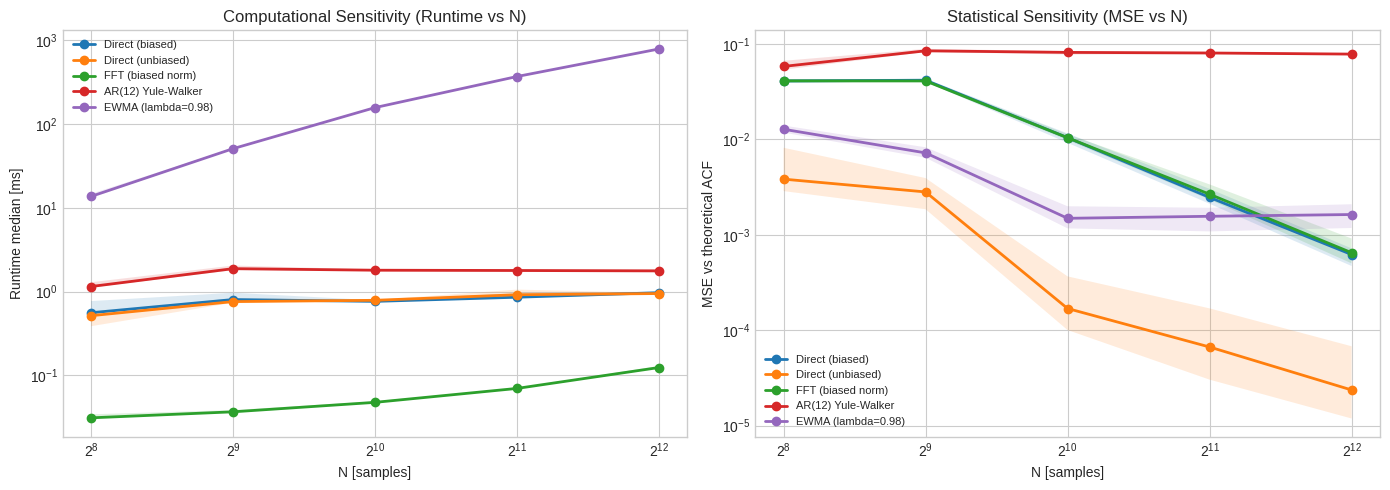

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Runtime scaling plot with median and IQR bands.
for method_name in timing_df["method"].unique():
    subset = timing_df[timing_df["method"] == method_name].sort_values("N")
    x_n = subset["N"].to_numpy(dtype=np.float64)
    y_med = subset["time_ms_median"].to_numpy(dtype=np.float64)
    y_p25 = subset["time_ms_p25"].to_numpy(dtype=np.float64)
    y_p75 = subset["time_ms_p75"].to_numpy(dtype=np.float64)

    axes[0].plot(x_n, y_med, marker="o", linewidth=2, label=method_name)
    axes[0].fill_between(x_n, y_p25, y_p75, alpha=0.15)

axes[0].set_xscale("log", base=2)
axes[0].set_yscale("log")
axes[0].set_xlabel("N [samples]")
axes[0].set_ylabel("Runtime median [ms]")
axes[0].set_title("Computational Sensitivity (Runtime vs N)")
axes[0].legend(fontsize=8)

# Statistical sensitivity plot with MSE median and IQR bands.
for method_name in error_df["method"].unique():
    subset = error_df[error_df["method"] == method_name].sort_values("N")
    x_n = subset["N"].to_numpy(dtype=np.float64)
    y_med = subset["mse_median"].to_numpy(dtype=np.float64)
    y_p25 = subset["mse_p25"].to_numpy(dtype=np.float64)
    y_p75 = subset["mse_p75"].to_numpy(dtype=np.float64)

    axes[1].plot(x_n, y_med, marker="o", linewidth=2, label=method_name)
    axes[1].fill_between(x_n, y_p25, y_p75, alpha=0.15)

axes[1].set_xscale("log", base=2)
axes[1].set_yscale("log")
axes[1].set_xlabel("N [samples]")
axes[1].set_ylabel("MSE vs theoretical ACF")
axes[1].set_title("Statistical Sensitivity (MSE vs N)")
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()


In [9]:
summary_df = build_summary_table(
    cfg=CONFIG,
    methods=METHOD_SPECS,
    timing_df=timing_df,
    error_df=error_df,
)

text_columns = ["complexity", "sample_size_sensitivity", "pros", "cons"]

summary_df.style.set_properties(
    subset=text_columns,
    **{"white-space": "normal", "text-align": "left"},
).set_properties(**{"text-align": "left"})


,method,time_at_maxN_ms,mse_at_maxN,empirical_time_exponent,empirical_mse_exponent,complexity,sample_size_sensitivity,pros,cons
0,FFT (biased norm),0.123896,0.000720,0.491840,-1.554320,"Theta(M log M), M ~= nextpow2(2N-1)",Runtime scales near N log N; good for many lags.,Fast for full or wide-lag ACF; numerically consistent with direct.,Pays FFT cost even when only a few lags are needed.
1,Direct (unbiased),0.946546,0.000049,0.202878,-1.855324,Theta(NK); Theta(N^2) when K ~= N,High-lag variance drops slowly; needs larger N for stable tails.,Unbiased covariance in expectation for each lag.,Variance explodes near K close to N.
2,Direct (biased),0.968685,0.000642,0.168177,-1.600249,Theta(NK); Theta(N^2) when K ~= N,Bias at high lags (k/N large); runtime grows with N and K.,"Simple baseline, deterministic behavior, strong at short lags.",Normalization bias at large lags; expensive for full ACF.
3,AR(12) Yule-Walker,1.763258,0.078209,0.116593,0.066756,Theta(Np + p^2 + Kp),Can be data-efficient if process is close to AR(p).,Smooth denoised ACF; compact parametric representation.,Model mismatch causes systematic error; needs p tuning.
4,EWMA (lambda=0.98),786.200795,0.001801,1.455674,-0.781056,"Theta(NK), O(K) memory",Accuracy saturates near effective memory 1/(1-lambda).,"Streaming-friendly, no full-record storage, tracks drift.",Not the full-record ACF; lambda controls bias/variance trade-off.


## Notes for Interpretation

- `empirical_time_exponent` is the fitted slope in `time ~ N^b` (log-log fit over `N_LIST`).
- `empirical_mse_exponent` is the fitted slope in `MSE ~ N^b`; more negative usually means error drops faster with `N`.
- For EWMA, statistical improvement can saturate when `N` exceeds the effective memory \(pprox 1/(1-\lambda)\).
- If you want a harsher computational stress test, set `max_lag_mode="full"` to use `K=N-1`.
